# JASA_DAG

Joint distance covariance(JdCov) and its Variants are employed to perform model selection in causal inference(DAG), which is based on the joint independence testing of the residuals from the fitted structural equation models.

In [1]:
library(dHSIC)
library(mgcv)
library(Matrix)
library(MASS)
library(parallel)
library(graph)
library(RBGL)
library(DAAG)
library(splitstackshape)
library(gRbase)
library(Rgraphviz)
library(energy)
library(mvtnorm)

Loading required package: nlme

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from 'package:Matrix':

    which


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, whic

## Data

A population of women who were at least 21 years old, of Pima Indian heritage and living near Phoenix, Arizona, was tested for diabetes according to World Health Organization(WHO) criteria. The data were collected by the U.S. National Institute of Diabetes and Digestive and Kidney Diseases. We downloaded the data from https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes.

1. focus only on the following five variables: Age, Body Mass Index (BMI), 2-Hour Serum Insulin (SI), Plasma Glucose Concentration (glu), and Diastolic Blood Pressure (DBP).
2. only selecte the instances with nonzero values, as it seems that zero values encode missing data. This yields n = 392 samples.
3. center each of the variables and scale them.

Age is likely to affect all the other variables (but of course not the other way round). Moreover, serum insulin also has plausible causal effects on BMI and plasma glucose concentration.

We try to determine the correct causal structure out of some candidate DAG(Directed Acyclic Graph) models from `TETRAD` and perform model diagnostic checking for each of the models


In [9]:
## Reading the data

rm(list = ls())
graphics.off()
set.seed(1234)
setwd('D:/Code/Econometrics/DAG/working/Rcodes_JdCov/Rcodes')
source('./JdCov.R')

pima_final_cs <- read.csv(file='./pima.csv')
print(dim(pima_final_cs))
print(head(pima_final_cs))

rn <- names(pima_final_cs)

n <- nrow(pima_final_cs)
d <- ncol(pima_final_cs)

X <- lapply(pima_final_cs, as.matrix)
names(X) <- paste0('X', 1:d) 

[1] 392   5
         age        BMI         SI        glu         DBP
1 -0.9682991 -0.7104210 -0.5228420 -1.0910458 -0.37365481
2  0.2095853  1.4267301  0.1006309  0.4663141 -2.45696436
3 -0.4775139 -0.2972385 -0.5733939 -1.4479408 -1.65569146
4  2.1727260 -0.3684768  3.2601217  2.4130139 -0.05314565
5  2.7616681 -0.4254675  5.8129903  2.1534540 -0.85441855
6  1.9764119 -1.0381175  0.1596080  1.4072190  0.10710893


## candidate DAG models

`allDags.txt`: Each column denote a candidate DAG model. Transform each column to a matrix by column. 

   V1 V2 V3 V4 V5 V6
1   0  0  0  0  0  0
2   0  0  0  1  0  0
3   0  0  0  1  0  0
4   0  0  0  1  1  0
5   1  0  0  0  0  0
6   1  0  0  0  1  1
7   0  0  0  0  0  0
8   0  0  0  0  0  1
9   0  0  1  0  0  0
10  0  0  0  1  1  0
11  0  0  0  0  1  1
12  0  0  0  0  0  0
13  0  0  0  0  0  0
14  0  0  0  0  0  0
15  0  1  0  0  1  0
16  0  0  0  0  0  1
17  0  1  0  0  0  0
18  0  1  0  1  1  1
19  0  0  0  0  0  0
20  0  0  0  1  0  0
21  0  1  1  0  0  1
22  0  0  0  0  0  0
23  0  0  0  0  0  0
24  0  0  1  0  0  1
25  0  0  0  0  0  0


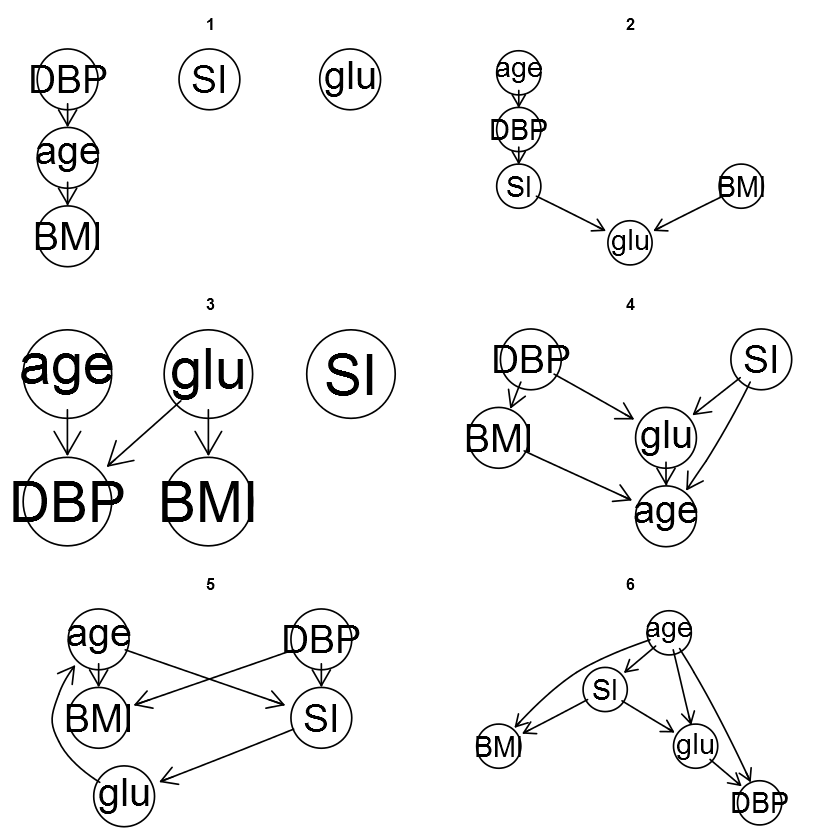

In [10]:
allDags_pima <- read.table('./allDags.txt', sep = ',')
V6 <- c(0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0)
allDags_pima <- cbind(allDags_pima, V6)
print(allDags_pima)

allDags_pima <- lapply(allDags_pima, 
                       function(x) matrix(x, d, d, dimnames = list(rn, rn)))
numDAGs_pima <- length(allDags_pima)

par(mfrow=c(ceiling(numDAGs_pima/2), 2))
for(i in 1:numDAGs_pima) {
  plot(graphAM(adjMat = allDags_pima[[i]], edgemode="directed"), main=i)
}
par(mfrow=c(1,1))

## Models selection based on JdCov

In [19]:
## initialize parameter
B=100 ; cc=1

# initalize pvalue vector
pval_dhsic_p <- vector("numeric",numDAGs_pima)
pval_Jdcov_p <- vector("numeric",numDAGs_pima)
pval_JdcovUS_p <- vector("numeric",numDAGs_pima)
pval_JdcovR_p <- vector("numeric",numDAGs_pima)
pval_MS16_p <- vector("numeric",numDAGs_pima)

# compute the p-value for each DAG model
  
for(i in 1:numDAGs_pima){
  
  A <- allDags_pima[[i]] 
  res <- rep(list(matrix(0, nrow=n, ncol=1)), d)
  fitgam <- rep(list(matrix(0, nrow=n, ncol=1)), d)
  
  # regress each node on its variables and collect the residuals
  for(j in 1:d){
    if(sum(A[,j])==0){
      res[[j]][,1] <- X[[j]]
    }
    else{
      formula <- paste("X",toString(j),"~",sep="")
      for(k in 1:d){
        if(A[k,j]==1){
          if((sum(A[,j])-sum(A[1:k,j]))==0){
            formula <- paste(formula,"s(X",toString(k),")",sep="")
          }
          else{
            formula <- paste(formula,"s(X",toString(k),")+",sep="")
          }
        }
      }
      g=gam(as.formula(formula),data=X)
      res[[j]][,1] = g$residuals
      fitgam[[j]][,1] = g$fitted.values
    }
  }
  
  x=res
  ## computing values of the original statistics
  stat.dhsic <- dhsic(X=x,kernel="gaussian")$dHSIC
  stat <- Jdcov.sq.U.list(x,cc) 
  stat.s <- Jdcov.sq.US.list(x,cc)
  
  x.r <- x
  for(j in 1:d) {
    for(l in 1:ncol(x[[j]])){
      f.cdf <- ecdf(x[[j]][,l]); x.r[[j]][,l] <- f.cdf(x[[j]][,l])
    }
  }
  
  stat.r <- Jdcov.sq.U.list(x.r,cc)
  stat4 <- 0
  for(b in 1:(d-1)) stat4 <- stat4 + dcovU(x[[b]],do.call(cbind,x[(b+1):d]))^2
  
  ## creating storage spaces for bootstrap resamples
  stat.pdhsic <- stat.p <- stat.pr <- stat.ps  <- stat.p4 <- rep(0, B)
  
  
  for(ii in 1:B)
  {
    res.B <- rep(list(matrix(0,nrow=n,ncol=1)), d)
    res.new <- rep(list(matrix(0,nrow=n,ncol=1)), d)
    Y.B = list()
    
    for(j in 1:d){
      res.B[[j]]=as.matrix(res[[j]][sample(1:n,n,replace=TRUE),])
      Y.B[[j]]=fitgam[[j]]+res.B[[j]]
    }
    XB <- Y.B
    names(XB) <- paste0('XB', 1:d)
    for(j in 1:d){
      if(sum(A[,j])==0){
        res.new[[j]][,1] <- XB[[j]]
      }
      else{
        formula <- paste("XB",toString(j),"~",sep="")
        for(k in 1:d){
          if(A[k,j]==TRUE){
            if((sum(A[,j])-sum(A[1:k,j]))==0){
              formula <- paste(formula,"s(XB",toString(k),")",sep="")
            }
            else{
              formula <- paste(formula,"s(XB",toString(k),")+",sep="")
            }
          }
        }
        # print(formula)
        gB=gam(as.formula(formula),data=XB)
        res.new[[j]][,1] <- gB$residuals
      }
    }
    
    x=res.new
    stat.pdhsic[ii] <- dhsic(X=x,kernel="gaussian")$dHSIC
    stat.p[ii] <- Jdcov.sq.U.list(x,cc) 
    stat.ps[ii] <- Jdcov.sq.US.list(x,cc)
    
    x.r <- x
    for(j in 1:d) {
      for(l in 1:ncol(x[[j]])){
        f.cdf <- ecdf(x[[j]][,l]); x.r[[j]][,l] <- f.cdf(x[[j]][,l])
      }
    }
    
    stat.pr[ii] <- Jdcov.sq.U.list(x.r,cc)
    stat.p4[ii] <- 0
    for(b in 1:(d-1)) stat.p4[ii] <- stat.p4[ii] + dcovU(x[[b]],do.call(cbind,x[(b+1):d]))^2
    
  }    
  
  pval_dhsic_p[i] = length(stat.pdhsic[stat.pdhsic > stat.dhsic]) /B 
  pval_Jdcov_p[i] = length(stat.p[stat.p > stat]) /B
  pval_JdcovUS_p[i] = length(stat.ps[stat.ps > stat.s]) /B
  pval_JdcovR_p[i] = length(stat.pr[stat.pr > stat.r]) /B
  pval_MS16_p[i] = length(stat.p4[stat.p4 > stat4]) /B
  
}

## result

[1] "dHIC"
    age BMI SI glu DBP
age   0   1  0   0   0
BMI   0   0  0   0   0
SI    0   0  0   0   0
glu   0   0  0   0   0
DBP   1   0  0   0   0
[1] "JdCov"
    age BMI SI glu DBP
age   0   1  1   1   1
BMI   0   0  0   0   0
SI    0   1  0   1   0
glu   0   0  0   0   1
DBP   0   0  0   0   0
[1] "JdCovUS"
    age BMI SI glu DBP
age   0   1  1   1   1
BMI   0   0  0   0   0
SI    0   1  0   1   0
glu   0   0  0   0   1
DBP   0   0  0   0   0
[1] "JdCovR"
    age BMI SI glu DBP
age   0   1  1   1   1
BMI   0   0  0   0   0
SI    0   1  0   1   0
glu   0   0  0   0   1
DBP   0   0  0   0   0
[1] "MT"
    age BMI SI glu DBP
age   0   1  1   1   1
BMI   0   0  0   0   0
SI    0   1  0   1   0
glu   0   0  0   0   1
DBP   0   0  0   0   0


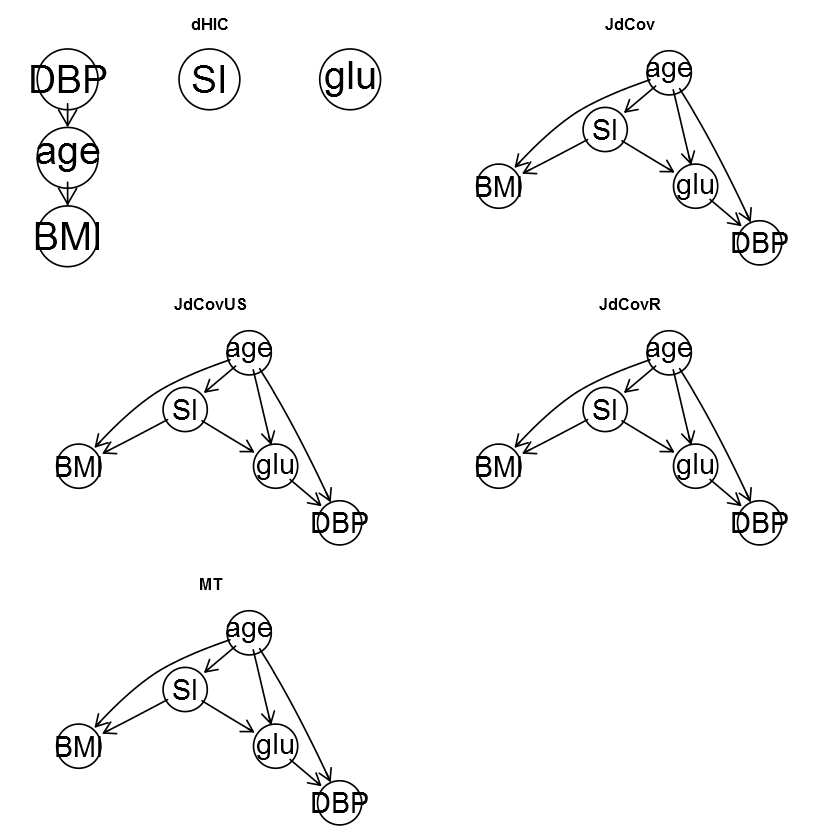

In [28]:
max.idx <- c(which.max(which.max(pval_dhsic_p)),
             which.max(pval_Jdcov_p),
             which.max(pval_JdcovUS_p),
             which.max(pval_JdcovR_p),
             which.max(pval_MS16_p))
cri.idx <- c('dHIC', 'JdCov', 'JdCovUS', 'JdCovR', 'MT')

for(i in 1:length(max.idx)) {
    print(cri.idx[i])
    print(allDags_pima[[max.idx[i]]])
    
}
par(mfrow = c(3,2))
for(i in 1:length(max.idx)) {
    plot(graphAM(adjMat = allDags_pima[[max.idx[i]]], edgemode="directed"), main = cri.idx[i])
}